## Analysis of the published data
In this notebook we analyze the CPC scores and their components, which a published every year by INEP. We first focus on the CPC scores, and their most import components, the ENADE score and the IDD scores. We will show that the CPC shows low correlations between the scores of the same courses assesed in 2014 and 2017. This is due for the most part to the IDD component (35% of the total CPC score). 

In comparing the data from 2014 and 2017 there is a restriction, as noted in the CreateDataset notebook: in 2014 results were still reported for the so-called "Unit of observation" instead of individual courses. Therefore, in this notebook we only compare combinations of area / institutions / municipalities with only one course, so that we can unambiguously compare 2014 and 2017.  

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
cpc17 = pd.read_csv('data/processed/cpc-pub-2017.csv')
cpc14 = pd.read_csv('data/processed/cpc-pub-2014.csv')

def filtered(df):
    df = df[df['N'] > 1]
    df = df[df['fracN'] > 0.2]
    return df
cpc17 = filtered(cpc17)
cpc14 = filtered(cpc14)

In [3]:
areas17 = {21:'Arquitetura e Urbanismo',
         72:'Tecnologia em Análise e Desenvolvimento de Sistemas',
         76:'Tecnologia em Gestão da Produção Industrial',
         79:'Tecnologia em Redes de Computadores',
         701:'Matemática (Bacharelado)',
         702:'Matemática (Licenciatura)',
         903:'Letras-Português (Bacharelado)',
         904:'Letras-Português (Licenciatura)',
         905:'Letras-Português e Inglês (Licenciatura)',
         906:'Letras-Português e Espanhol (Licenciatura)',
         1401:'Física (Bacharelado)',
         1402:'Física (Licenciatura)',
         1501:'Química (Bacharelado)',
         1502:'Química (Licenciatura)',
         1601:'Ciências Biológicas (Bacharelado)',
         1602:'Ciências Biológicas (Licenciatura)',
         2001:'Pedagogia (Licenciatura)',
         2401:'História (Bacharelado)',
         2402:'História (Licenciatura)',
         2501:'Artes Visuais (Licenciatura)',
         3001:'Geografia (Bacharelado)',
         3002:'Geografia (Licenciatura)',
         3201:'Filosofia (Bacharelado)',
         3202:'Filosofia (Licenciatura)',
         3502:'Educação Física (Licenciatura)'
}

### The IDD indicator looks likes noise
We start with looking at the indicators for one year, plotting the value of the indicator as a function of how many participants participated in the ENADE exam for that course. Off course, if a mean is taken from N independent draws from a random number generator, we expect the standard deviation of this mean to go down $\propto 1/\sqrt(N)$. On the other hand, if an indicator really reflects meaningful differences between courses, and the measure of the indicator is not completely dominated by random fluctuations, then we expect to see much less dependence of the indicator as a function of N.

We show below that for IDD, the dependence on N is marked, and much less so for ENADE.

In [4]:
def random_averages(Ns=[],mu=0,sigma=1):
    'returns an array of averages, given an array of Ns'
    Ns = [round(N) for N in Ns]
    return [np.random.normal(mu,sigma,N).mean() for N in Ns]

#random_averages([2,3.0,4,52])

1193183


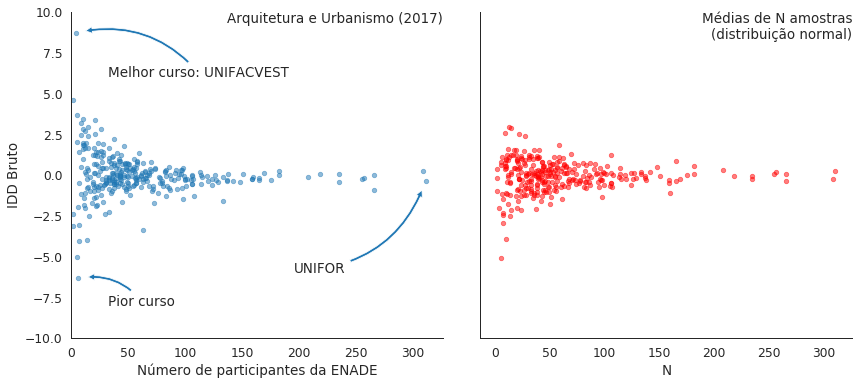

In [5]:
def rankfig(area,ano,jittered = True,indicator='idd',savefig=False):
    if ano == 2017:
        r = cpc17.query("area == @area")
    else:
        r = cpc14.query("area == @area")
    r = r.sort_values('N')
    r = r[abs(r['idd']) < 10]
    if jittered:
        r['x'] = r['N'].apply(np.random.normal,scale=0.5)
    else:
        r['x'] = r['N']
    if indicator == 'idd':
        r['simulated'] = random_averages(r['x'],mu=0,sigma=5)
    elif indicator in ['cpc','enade']:
        r['simulated'] = random_averages(r['x'],mu=2.5,sigma=2)
    
    sns.set_style('white')
    sns.set_context('paper',font_scale=1.4)
    #fig = plt.figure(figsize=(8,5))
    _,axs = plt.subplots(1,2,figsize=(14,6),sharey=True)
    ax = axs[0]
    r.plot(kind='scatter',x='x',y=indicator,alpha=0.5,ax=ax)
    if indicator == 'idd':
        ax.set_ylim(-10,10)
        ax.set_ylabel("IDD Bruto")
    elif indicator == 'cpc':
        ax.set_ylim(0,5)
        ax.set_ylabel("CPC")
    elif indicator == 'enade':
        ax.set_ylim(0,5)
        ax.set_ylabel("ENADE")
    
    ax.set_xlabel('Número de participantes da ENADE')
    ax.set_xlim(0)
    ax.text(1,1,areas17[area] +" ("+str(ano)+")",
            horizontalalignment='right',
            verticalalignment='top',transform=ax.transAxes)
    if area == 21 and ano == 2017 and indicator in ['cpc','idd']:
        lastx = r['x'].iloc[-1];lasty = r[indicator].iloc[-1]
        firstx = r['N'].loc[r[indicator].idxmax()];firsty = r[indicator].max()
        worstx = r['N'].loc[r[indicator].idxmin()];worsty = r[indicator].min()
        #last_course = r['curso'].iloc[-1]
        first_course = r['curso'].loc[r[indicator].idxmax()]
        worst_course = r['curso'].loc[r[indicator].idxmin()]
        print(worst_course)
    
        ax.annotate("UNIFOR",(lastx,lasty),xytext=(0.6,0.2),
                    textcoords='axes fraction',
                    arrowprops={'arrowstyle':'simple',
                                'connectionstyle':'arc3,rad=0.3',
                                'shrinkB':10})
        ax.annotate('Melhor curso: UNIFACVEST',(firstx,firsty),xytext=(0.1,0.8),
                    textcoords='axes fraction',
                    arrowprops={'arrowstyle':'simple',
                                'connectionstyle':'arc3,rad=0.3',
                                'shrinkB':10})
        ax.annotate('Pior curso',(worstx,worsty),xytext=(0.1,0.1),
                    textcoords='axes fraction',
                    arrowprops={'arrowstyle':'simple',
                                'connectionstyle':'arc3,rad=0.3',
                                'shrinkB':10})
    sns.despine()
    
    ax = axs[1]
    r.plot(kind='scatter',x='x',y='simulated',alpha=0.5,color='r',ax=ax)
    ax.set_xlabel('N')
    ax.set_ylabel('')
    ax.text(1,1,"Médias de N amostras\n(distribuição normal)",
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes)

    plt.subplots_adjust(wspace=0.1)
    if savefig:
        for dpi in [50,300]:
            fn = 'figs/funnel-{}-{}-{}-{}.png'.format(indicator,area,ano,dpi)
            plt.savefig(fn,dpi=dpi)
    
rankfig(21,2017,jittered=False,indicator='idd',savefig=True)

The larger variance of low N courses as compared to high N courses, is typical of a stochastic process in which the metric is the mean of a random variable (the mean of which has variance $ \propto 1/N $. Below, we show that this is not case for another metric, the mean ENADE score of students. 

The *Standards for educational and psychological testing* say (p33) "the need for precision increases as the consequences of decisions and interpretations grow in importance. The most important conseguence of the CPC metric (in which the IDD takes a 35% part) is that low scoring courses will be visited *in loco* for reaccreditation purposes. It is therefore ironic that it's exactly the courses for which the metric is determined with lowest precision are the courses which will suffer the most important conseguences. 

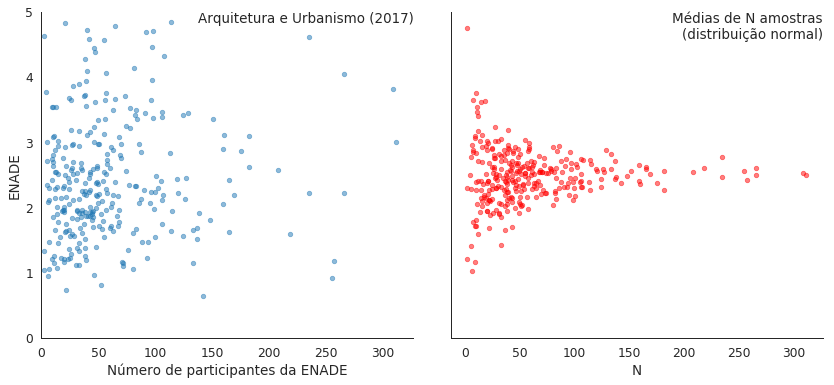

In [6]:
rankfig(21,2017,jittered=False,indicator='enade')

### Correlations between years
Ikuta [1] warns that CPCs from diferent years cannot be directly compared, because of 
1. chances in the weights of the components and how some components are calculated
2. the fact that the components are standarized with respect to all courses (within one area) assessed in one year.

Point 2 does not matter for correlations. Point 1 must be taken account and we do that by correlating only components like the ENADE or IDD whose calculation did not chance. It can be noted also the since 2013 the weights of the components of the CPC indicator have not changed.

A more important point is that before 2015 we should only use "units of observation" with only one course, because before that year some IES had night-time, daytime and/or distance education courses within one municipality and their indicators were reported as an average of all these courses. Therefore we take these courses out of the sample, including only those courses with 1 course per unit of observation. This may lead to some bias, since it larger courses are taken out of the sample.


[1] IKUTA, C. Y. S. Sobre o Conceito Preliminar de Curso: concepção, aplicação e mudanças metodológicas. Estudos em Avaliação Educacional, v. 27, n. 66, p. 938, 22 dez. 2016. 


In [7]:
print(cpc14.Ncp.describe(),'\n\n',cpc14[cpc14['Ncursos'] == 1].Ncp.describe())

count    7127.000000
mean       45.339834
std       164.843592
min         0.000000
25%        15.000000
50%        27.000000
75%        47.000000
max      9739.000000
Name: Ncp, dtype: float64 

 count    6592.000000
mean       37.052033
std        64.292451
min         0.000000
25%        15.000000
50%        26.000000
75%        43.000000
max      3497.000000
Name: Ncp, dtype: float64


In [8]:
def mergeyears(df1,df2,on=[],validate='',newcols={}):
    ''
    df = pd.merge(df1,df2,on=on,how='inner',validate=validate)
    df.rename(columns=newcols,inplace=True)
    print("courses: ",len(df))
    return df

newcols = {'idd_x':'idd14','idd_y':'idd17','cpc_x':'cpc14','cpc_y':'cpc17',
            'enade_x':'enade14','enade_y':'enade17',
            'Ncp_x':'Ncp14','Ncp_y':'Ncp17'}
df = mergeyears(cpc14[cpc14['Ncursos'] == 1],cpc17,on=['area','ies','municipio'],validate='1:m',newcols=newcols)

courses:  5543


In [9]:
df.sample(5)

,area,ies,municipio,Ncursos,Nci_x,Ncp14,enade14,N_x,fracN_x,idd14,...,curso,Nci_y,Ncp17,enade17,N_y,fracN_y,idd17,cpc17,cpcf_y,ano_y
212,72,502,3548500,1,45,33,1.870171,21,0.636364,0.361847,...,97739,31,25,2.705553,13.0,0.520000,2.870451,3.494976,4,2017
2773,2401,634,4314407,1,11,10,1.386773,7,0.700000,-0.992790,...,113619,44,34,2.050025,32.0,0.941176,0.381906,3.129317,4,2017
1329,1501,5,2211001,1,45,39,1.903384,27,0.692308,-0.435179,...,519,33,30,2.176440,29.0,0.966667,-0.496946,2.533188,3,2017
5134,6208,581,4314902,1,53,51,4.184298,19,0.372549,1.122088,...,45020,73,67,4.833123,57.0,0.850746,1.252938,3.759964,4,2017
1632,1601,349,3106200,1,19,17,2.915072,12,0.705882,2.727083,...,88241,30,27,2.765938,23.0,0.851852,0.887283,3.472877,4,2017


courses:  5543


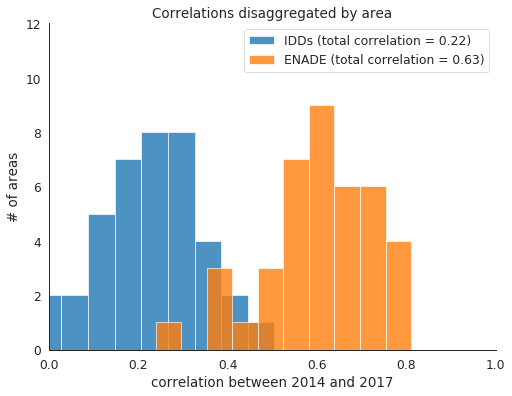

In [10]:
fig = plt.figure(figsize=(8,6))
sns.set_context('paper',font_scale=1.4)
sns.set_style('white')
alpha = 0.8

def corrfig(df,corrcols=[],savefig=False):
    for corrcol in corrcols:
        if corrcol == 'idd':
            corr = df[['idd14','idd17']].corr().iloc[0,1]
            corrs = df[['area','idd14','idd17']].groupby('area').corr().iloc[0::2,-1].sort_values()
            corrs.hist(label="IDDs (total correlation = {:.2f})".format(corr),alpha=alpha)
        elif corrcol == 'enade':
            corr = df[['enade14','enade17']].corr().iloc[0,1]
            corrs = df[['area','enade14','enade17']].groupby('area').corr().iloc[0::2,-1].sort_values()
            corrs.hist(label="ENADE (total correlation = {:.2f})".format(corr),alpha=alpha)
        elif corrcol == 'cpc':
            corr = df[['cpc14','cpc17']].corr().iloc[0,1]
            corrs = df[['area','cpc14','cpc17']].groupby('area').corr().iloc[0::2,-1].sort_values()
            corrs.hist(label="CPC (total correlation = {:.2f})".format(corr),alpha=alpha)
    
    ax = plt.gca()
    ax.set_title("Correlations disaggregated by area")
    ax.set_ylim(0,12)
    ax.set_xlim(0,1)
    ax.set_ylabel("# of areas")
    ax.set_xlabel("correlation between 2014 and 2017")
    ax.grid(False)
    plt.legend()
    sns.despine()
    if savefig:
        for dpi in [50,100,300]:
            fn = 'figs/corrs-14-17-{}.png'.format(dpi)
            plt.savefig(fn,dpi=dpi)
newcols = {'idd_x':'idd14','idd_y':'idd17','cpc_x':'cpc14','cpc_y':'cpc17',
            'enade_x':'enade14','enade_y':'enade17',
            'Ncp_x':'Ncp14','Ncp_y':'Ncp17'}
df = mergeyears(cpc14[cpc14['Ncursos'] == 1],cpc17,on=['area','ies','municipio'],validate='1:m',newcols=newcols)
corrfig(df,['idd','enade'],savefig=True)

The figure above says it all, but it's instructive to see what these correlations look like. Let's take first one area, and then plot all areas. 

/home/ewout/.conda/envs/idd/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


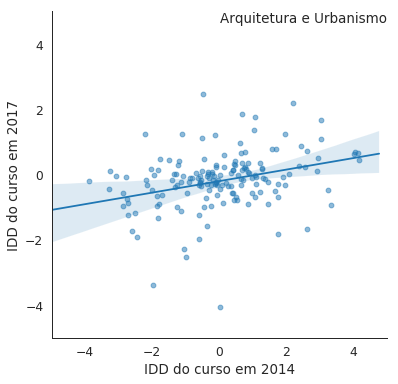

In [11]:
area=21
fig = plt.figure(figsize=(6,6))
sns.regplot(data=df.query("area == @area"),x='idd14',y='idd17',scatter_kws={'alpha':0.5})
ax = plt.gca()
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_xlabel("IDD do curso em 2014")
ax.set_ylabel("IDD do curso em 2017")
ax.text(1,1,areas17[area],
            horizontalalignment='right',
            verticalalignment='top',transform=ax.transAxes);
sns.despine()

for dpi in [50,300]:
     fn = 'figs/corr-21-14-17-{}.png'.format(dpi)
     plt.savefig(fn,dpi=dpi)

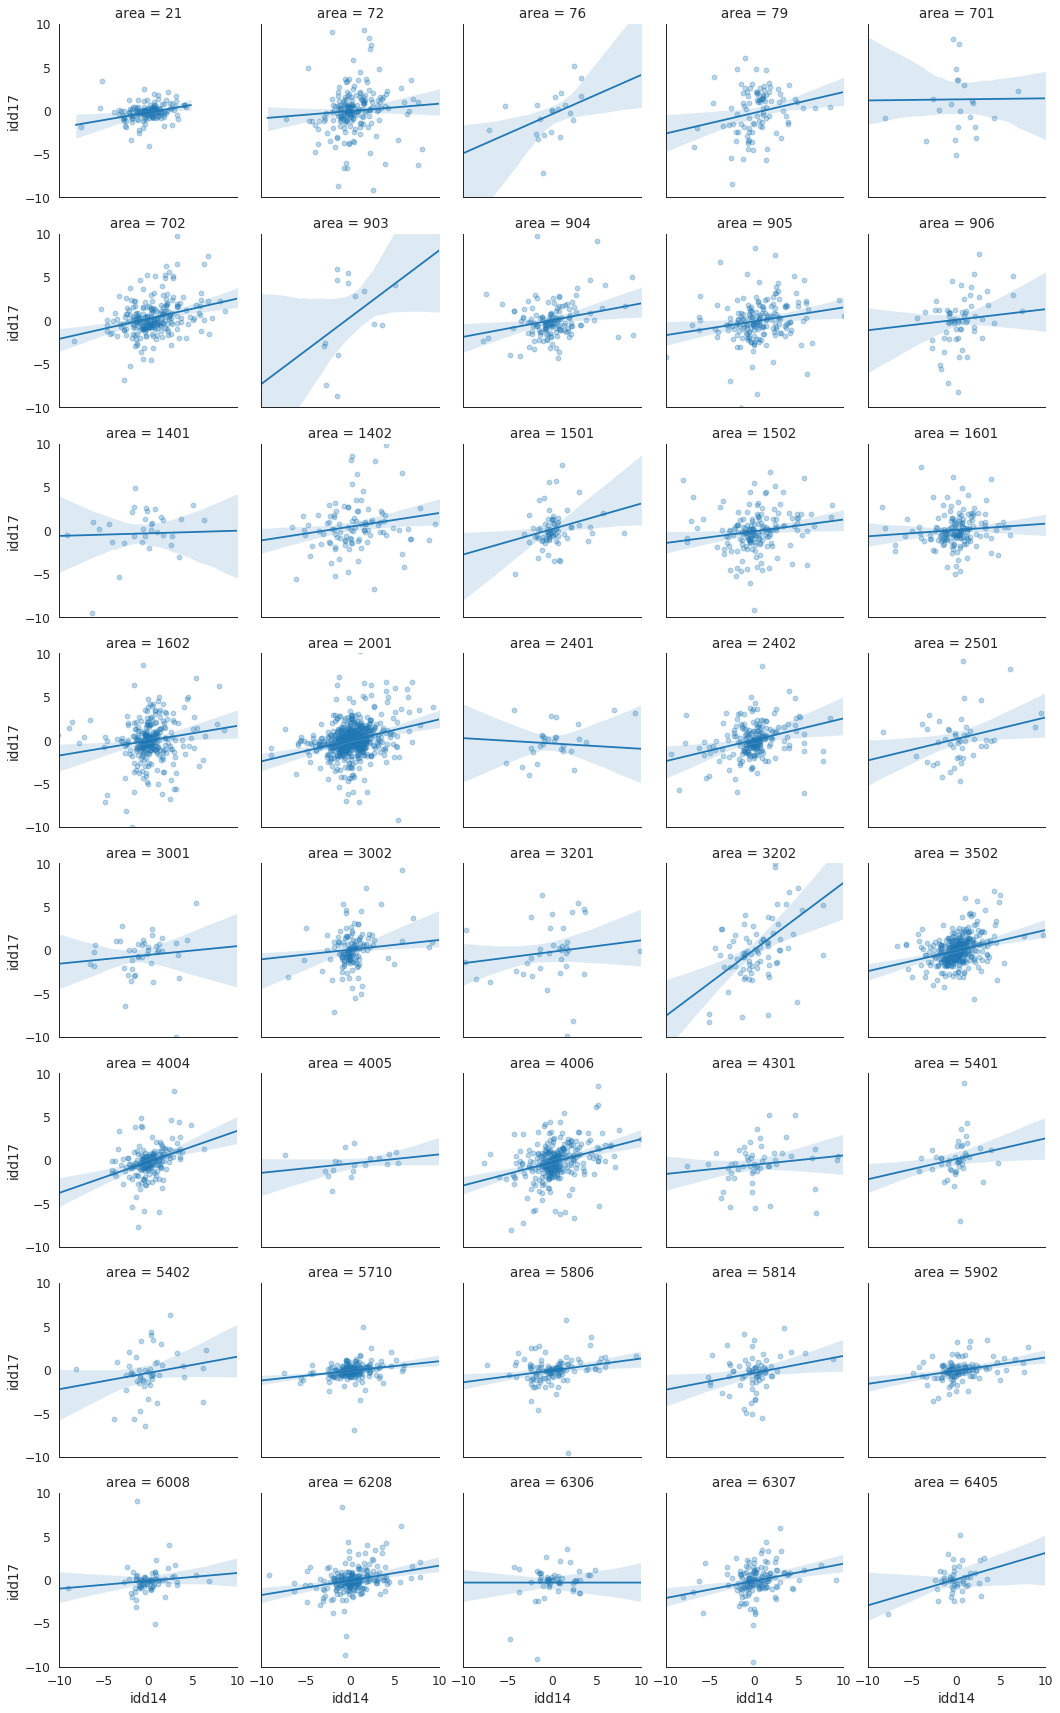

In [12]:
g = sns.FacetGrid(df,col='area',height=3,col_wrap=5)
g.map(sns.regplot,'idd14','idd17',scatter_kws={'alpha':0.3});
g.set(xlim=(-10,10))
g.set(ylim=(-10,10))

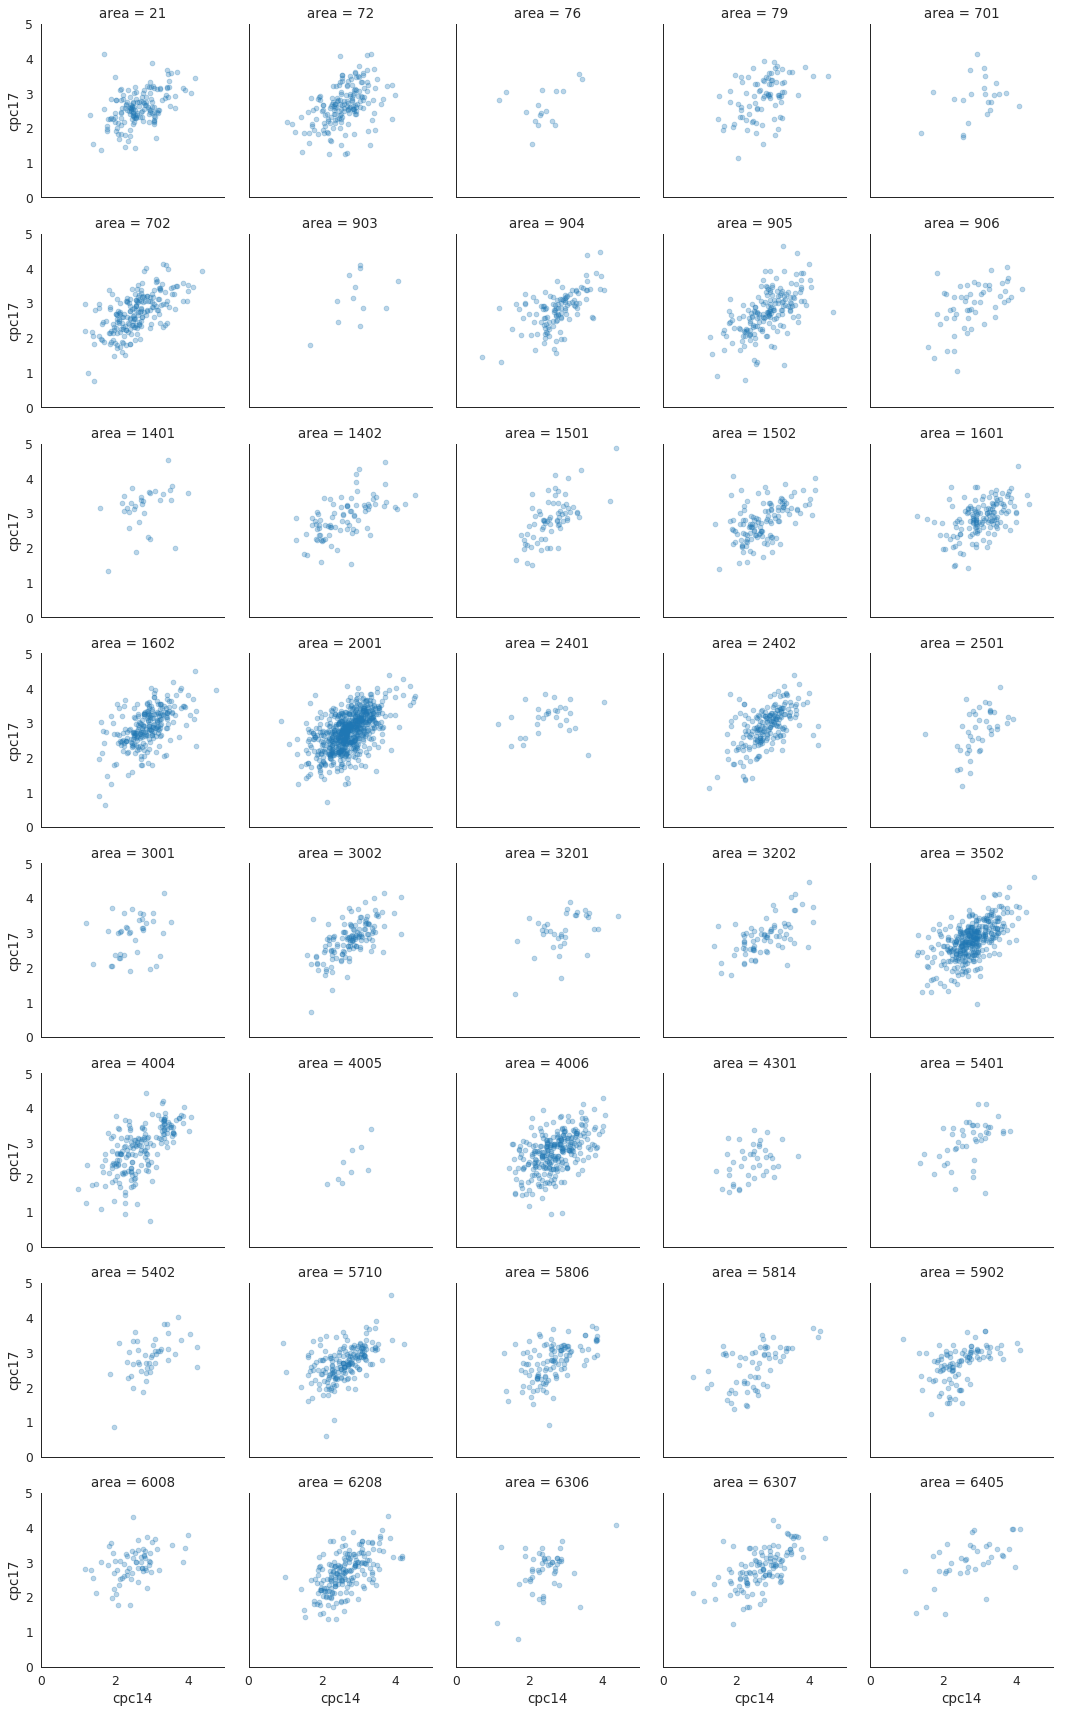

In [13]:
g = sns.FacetGrid(df,col='area',height=3,col_wrap=5)
g.map(plt.scatter,'cpc14','cpc17',alpha=0.3);
g.set(xlim=(0,5))
g.set(ylim=(0,5))

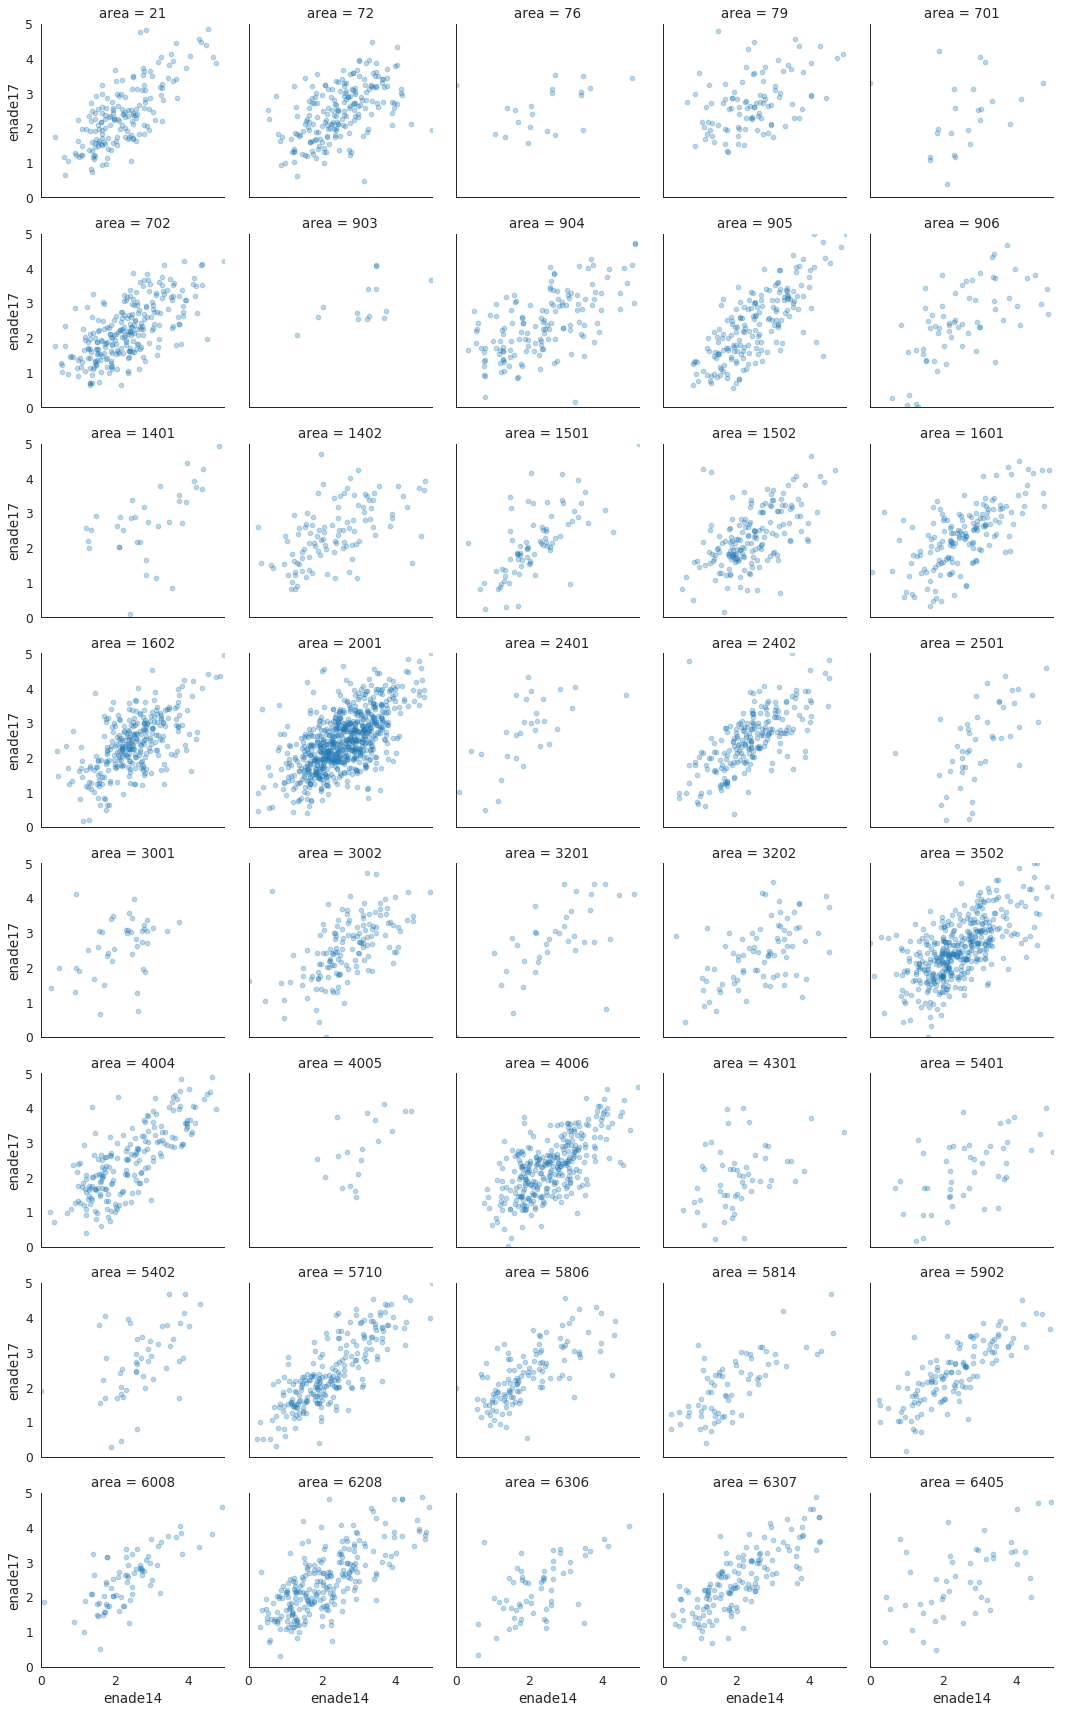

In [14]:
g = sns.FacetGrid(df,col='area',height=3,col_wrap=5)
g.map(plt.scatter,'enade14','enade17',alpha=0.3);
g.set(xlim=(0,5))
g.set(ylim=(0,5))

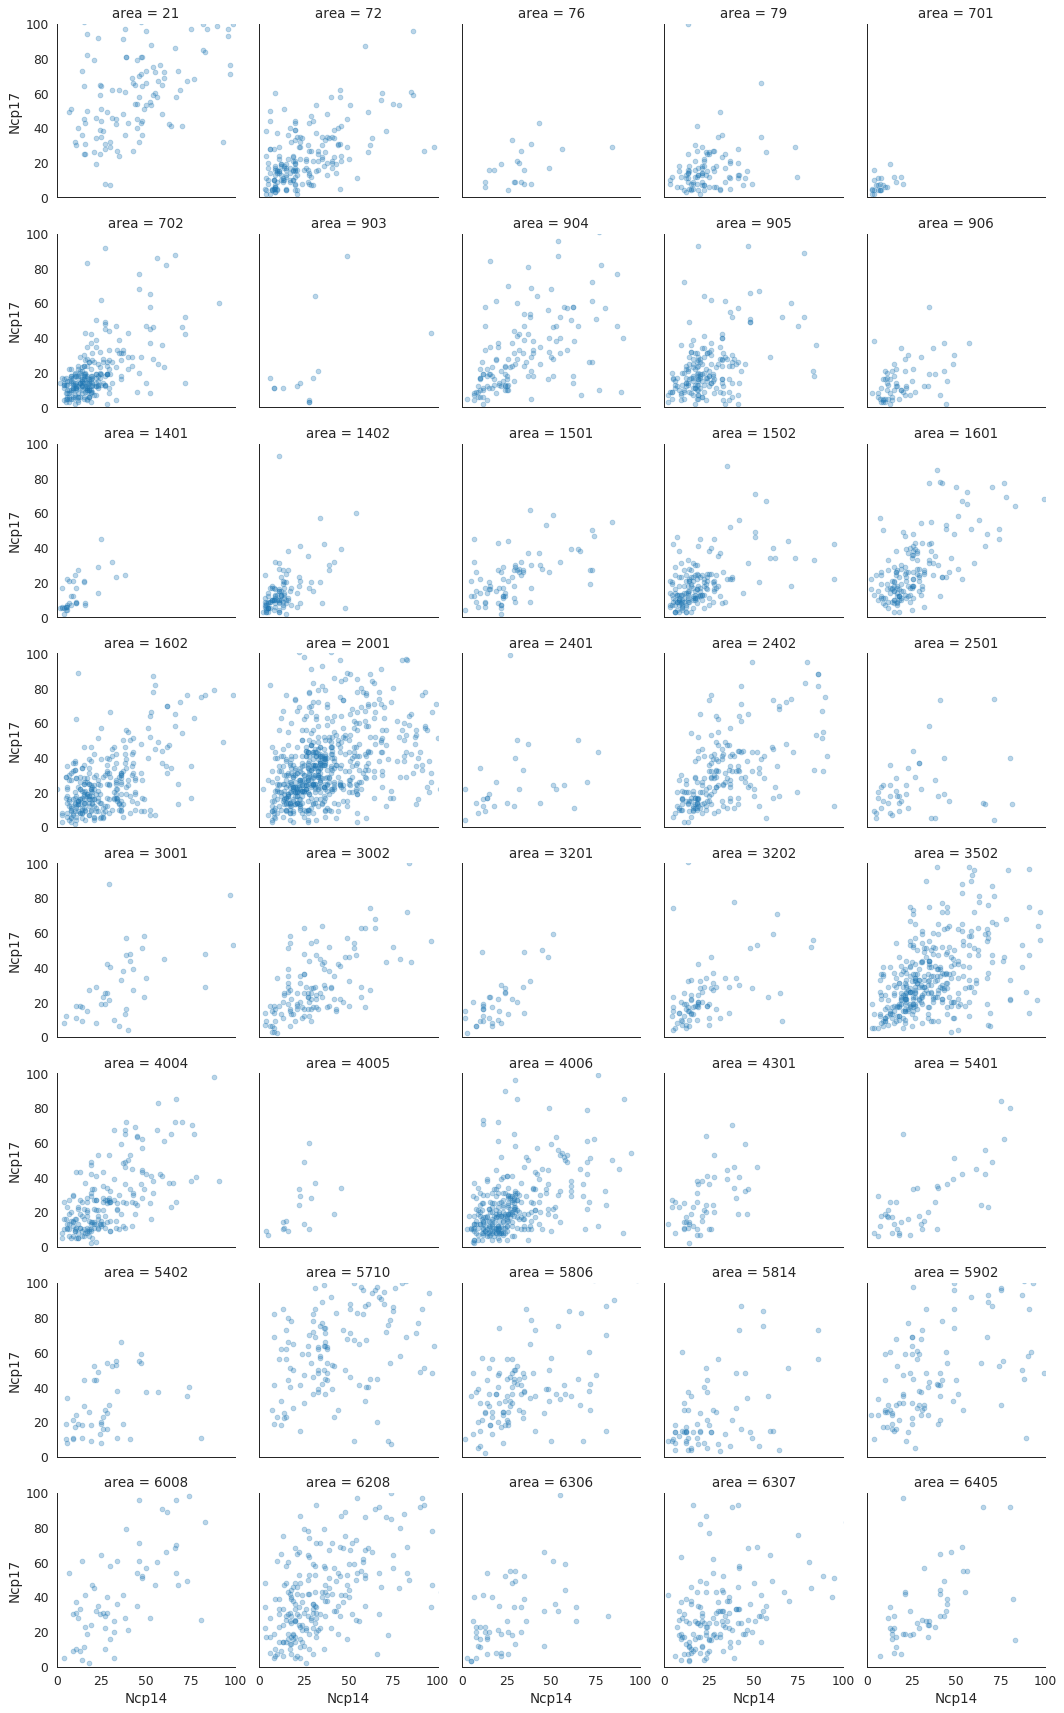

In [15]:
g = sns.FacetGrid(df,col='area',height=3,col_wrap=5)
g.map(plt.scatter,'Ncp14','Ncp17',alpha=0.3);
g.set(xlim=(0,100))
g.set(ylim=(0,100))